In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import butter, sosfiltfilt
import os
from collections import defaultdict
import pandas as pd
import copy
from matplotlib.lines import Line2D
from scipy.signal import butter, sosfiltfilt
from matplotlib.patches import PathPatch
import importlib
from src import ue_traj_seg
import csv
import ptitprince as pt
import seaborn as sns
import pickle

In [2]:
importlib.reload(ue_traj_seg)

<module 'src.ue_traj_seg' from 'C:\\Users\\kjack\\Documents\\Mason\\Research\\UE-traj-seg\\src\\ue_traj_seg.py'>

Linked Sections:

[Haptic Virtual Environment](#b)

[Targeted Box and Blocks](#c)

# Haptic virtual environment (HVE)
<a id='b'></a>

Read in some helper functions

In [3]:
def process_raw_data(fname):
    """
    For each trial, show the stroke identifier and number of frames, where the strokes are in order.
    
    """
    with open(fname, newline='') as csvfile:

        rows = []

        reader = csv.reader(csvfile)
        i = 0
        for row in reader:

            # Stroke Identifier
            if i == 0:
                identifiers = [x.strip() for x in row]

            # Total time
            elif i == 1:
                total_time = [x.strip() for x in row]

            # Column headers
            elif i == 2:
                column_headers = [x.strip() for x in row]

            # Position at start, which jumps to the first grab. Hence not using it here.
            elif i == 3:
                pass

            # Trajectory data
            else:
                rows.append([x.strip() for x in row])

            i += 1

        # convert data to a pandas dataframe for parsing
        df = pd.DataFrame(rows, columns=column_headers)
    
    return df, int(total_time[1]), identifiers

def list_subdirs(directory):
    r = []
    for root, dirs, files in os.walk(directory):
        [r.append(x) for x in dirs]
        break
    return r

def process_all_df(top_dir):
    """
    top_dir should point to "path/to/The DATA!!!/Subjects/"
    """

    r = list_subdirs(top_dir)

    # remove subject 0
    r.remove('Subject #0')

    subject_workbench_data = {}
    for subject in r:
        subject_workbench_data[subject] = {}

        trial_fnames = os.listdir(os.path.join(top_dir, subject, 'Clean_Workbench_Data'))
        
        # hidden files
        trial_fnames = [i for i in trial_fnames if i[0] != '.']

        for trial in trial_fnames:
            
            full_path = os.path.join(top_dir, subject, 'Clean_Workbench_Data', trial)
            trial_num = int(trial[4])
            subject_workbench_data[subject][trial_num] = {}
            subject_workbench_data[subject][trial_num]['data'], subject_workbench_data[subject][trial_num]['total_time'], subject_workbench_data[subject][trial_num]['identifiers'] = process_raw_data(full_path)
            subject_workbench_data[subject][trial_num]['total_frames'] = len(subject_workbench_data[subject][trial_num]['data'])
    
    return subject_workbench_data

Specify file location for data

In [4]:
# windows
top_dir = 'path\\to\\data\\HVE\\Subjects'

subject_workbench_data = process_all_df(top_dir)

In [6]:
duplicates_hve = ['2_3_2', '2_3_4', '2_3_6', '2_3_8', '2_3_12']

statistics = {}
error_stats_dict = defaultdict(list)
no_dwell = defaultdict(list)

abs_dev_dict = {}
abs_mean_dict = {}
percent_of_move = defaultdict(list)
std_dict = {}
seg_indx_dict = {}
errors_dict = defaultdict(dict)

# for plotting acceptable/unaccetable results
all_stats_dict = {
    'kinematic' : {},
    'jackson' : {},
    'jackson_no_d' : {},
    '50_percent' : {},
    'sakai' : {}
}

# 5th order lowpass butterworth filter with cutoff frequency of 10, sampling at 30 Hz
sos = butter(5, 10, btype='lowpass', output='sos', fs=30)

failure_tracker = []
for subject, value in subject_workbench_data.items():
    subject_id = int(subject[9:])
    statistics[subject_id] = {}

    for trial, all_data in value.items():
        
        # these strokes are the trajectories to feed into ATPS
        stroke_tracker = []
        for tool in ['Hammer', 'Saw', 'Drill', 'Pliers', 'Wrench', 'Screwdriver']:
            idents = all_data['identifiers'][1:-1]
            t_index = idents.index(tool)

            if t_index == 1:
                # tool missing reaching/targeting trajectory
                stroke_tracker.append((tool, None))
            else:
                stroke_tracker.append((tool, str(idents[t_index-3])))
        
        statistics[subject_id][trial] = {}
        
        # coordinates
        x_coords = all_data['data']['X-Axis_Position(mm)'].astype(float)
        y_coords = all_data['data']['Y-Axis_Position(mm)'].astype(float)
        z_coords = all_data['data']['Z-Axis_Position(mm)'].astype(float)
        
        # identifier mask
        for tool, idx in stroke_tracker:
            
            # create concat ID
            new_id = str(subject_id) + "_" + str(trial) + "_" + str(idx)
            
            se_list = []
            
            if idx is not None and new_id not in duplicates_hve:

                statistics[subject_id][trial][idx] = {}
                
                mask = all_data['data']['Stroke#'] == idx
                x_traj, y_traj, z_traj = np.array(x_coords[mask].astype(float)), np.array(y_coords[mask].astype(float)), np.array(z_coords[mask].astype(float))

                x_squared_dist = np.square(np.diff(x_traj,  axis=0))
                y_squared_dist = np.square(np.diff(y_traj,  axis=0))
                z_squared_dist = np.square(np.diff(z_traj,  axis=0))

                dists = np.sqrt(np.sum(np.dstack((x_squared_dist, y_squared_dist, z_squared_dist)), axis=-1))[0]
                velocity_profile =  dists / (1/30)
                

                vel = sosfiltfilt(sos, velocity_profile)
                
                # do segmentation
                w_vals, w_thresh_indx, seg_indx, traj_displacement = ue_traj_seg.segmentation(x_traj, y_traj, z_traj, vel=vel, alpha=0.4)
                
                # compute mjt mae
                mjt = ue_traj_seg.min_jerk_traj_vel(x_traj, y_traj, z_traj, seg_indx)
                error_time_series = ue_traj_seg.mjt_error(mjt, vel[:seg_indx+1])
                statistics[subject_id][trial][idx]['raw_error'] = error_time_series

                statistics[subject_id][trial][idx]['mjt_vel'] = mjt
                statistics[subject_id][trial][idx]['real_vel'] = vel[:seg_indx+1]
                
                # viz jackson approach
                se_list.append(('jackson', seg_indx))


                # absolute deviation
                a_dev = np.std(np.abs(error_time_series))
                error_stats_dict['absolute_deviation'].append(a_dev)
                abs_dev_dict[new_id] = a_dev

                # absolute mean
                a_mean = np.mean(np.abs(error_time_series))
                
                # jackson
                all_stats_dict['jackson'][new_id] = a_mean

                # 50%
                per_move_indx = round(len(vel) * .5)
                mjt = ue_traj_seg.min_jerk_traj_vel(x_traj, y_traj, z_traj, per_move_indx)
                mjt_mae = np.mean(np.abs(ue_traj_seg.mjt_error(mjt, vel[:per_move_indx+1])))
                percent_of_move['50_percent'].append(mjt_mae)
                se_list.append(('50_percent', per_move_indx))
                all_stats_dict['50_percent'][new_id] = mjt_mae                
                
                # Kinematic threshold and zero crossing only, from Sakai
                se = ue_traj_seg.kin_threshold_and_zerocrossing(x_traj, y_traj, z_traj, vel=vel)
                mjt = ue_traj_seg.min_jerk_traj_vel(x_traj, y_traj, z_traj, se)
                error_stats_dict['kinematic_zvc'].append(np.mean(np.abs(ue_traj_seg.mjt_error(mjt, vel[:se+1]))))
                all_stats_dict['kinematic'][new_id] = np.mean(np.abs(ue_traj_seg.mjt_error(mjt, vel[:se+1])))
                se_list.append(('kinematic', se))

                # Sakai approach, c_1=2
                approx_ep = ue_traj_seg.find_approx_endpoint(x_traj, y_traj, z_traj, c_1=2, c_2=3, vel=vel, use_c2=True, alpha=0.4)
                if approx_ep[0] is None:
                    se = approx_ep[4]
                else:
                    se = approx_ep[2]
                mjt = ue_traj_seg.min_jerk_traj_vel(x_traj, y_traj, z_traj, se)
                error_stats_dict['sakai_abs_mean'].append(np.mean(np.abs(ue_traj_seg.mjt_error(mjt, vel[:se+1]))))
                se_list.append(('sakai', se))
                all_stats_dict['sakai'][new_id] = np.mean(np.abs(ue_traj_seg.mjt_error(mjt, vel[:se+1])))

                # absolute mean for paper plot
                a_mean = np.mean(np.abs(ue_traj_seg.mjt_error(mjt, vel[:se+1])))
                abs_mean_dict[new_id] = a_mean
                seg_indx_dict[new_id] = se
        
                # for plotting MJT MAE example
                errors_dict[new_id]['mjt_vel'] = mjt
                errors_dict[new_id]['real_vel'] = vel[:se+1]
    
    
                # check to see if any traj are too short
                if approx_ep[0] is None:
                                    
                    mjt = ue_traj_seg.min_jerk_traj_vel(x_traj, y_traj, z_traj, approx_ep[4])
                    no_dwell['c1_2_sakai_seg'].append(np.mean(np.abs(ue_traj_seg.mjt_error(mjt, vel[:approx_ep[4]+1]))))
                    no_dwell['c1_2_proposed_seg'].append(np.mean(np.abs(error_time_series)))
                    
                # Sakai approach, c_1=1
                approx_ep = ue_traj_seg.find_approx_endpoint(x_traj, y_traj, z_traj, c_1=1, c_2=3, use_c2=True)
                if approx_ep[0] is None:
                    se = approx_ep[4]
                else:
                    se = approx_ep[2]
                mjt = ue_traj_seg.min_jerk_traj_vel(x_traj, y_traj, z_traj, se)
                # check to see if any traj are too short
                if approx_ep[0] is None:
                                    
                    mjt = ue_traj_seg.min_jerk_traj_vel(x_traj, y_traj, z_traj, approx_ep[4])
                    no_dwell['c1_1_sakai_seg'].append(np.mean(np.abs(ue_traj_seg.mjt_error(mjt, vel[:approx_ep[4]+1]))))
                    no_dwell['c1_1_proposed_seg'].append(np.mean(np.abs(error_time_series)))
                
                
                #### without distance threshold ### 
                
                # jackson approach
                w_vals, w_thresh_indx, seg_indx, traj_displacement = ue_traj_seg.segmentation(x_traj, y_traj, z_traj, vel=vel, alpha=0.2, d_threshold=False)
                mjt = ue_traj_seg.min_jerk_traj_vel(x_traj, y_traj, z_traj, seg_indx)
                error_time_series = ue_traj_seg.mjt_error(mjt, vel[:seg_indx+1])
                mjt_mae = np.mean(np.abs(error_time_series))
                error_stats_dict['jackson_nodist'].append(mjt_mae)
                
                se_list.append(('jackson_no_d', seg_indx))
                all_stats_dict['jackson_no_d'][new_id] = mjt_mae
                
                # Sakai
                # Sakai approach
                approx_ep = ue_traj_seg.find_approx_endpoint(x_traj, y_traj, z_traj, c_1=2, c_2=3, use_c2=True, d_threshold=False)
                if approx_ep[0] is None:
                    se = approx_ep[4]
                else:
                    se = approx_ep[2]
                mjt = ue_traj_seg.min_jerk_traj_vel(x_traj, y_traj, z_traj, se)
                error_stats_dict['sakai_abs_mean_nodist'].append(np.mean(np.abs(ue_traj_seg.mjt_error(mjt, vel[:se+1]))))
                
                # check to see if any traj are too short
                if approx_ep[0] is None:
                                    
                    mjt = ue_traj_seg.min_jerk_traj_vel(x_traj, y_traj, z_traj, approx_ep[4])
                    no_dwell['nodist_sakai_seg'].append(np.mean(np.abs(ue_traj_seg.mjt_error(mjt, vel[:approx_ep[4]+1]))))
                    no_dwell['nodist_proposed_seg'].append(np.mean(np.abs(error_time_series)))

                ###### Sakai without c2

                # Sakai
                approx_ep = ue_traj_seg.find_approx_endpoint(x_traj, y_traj, z_traj, c_1=2, c_2=3, use_c2=False, d_threshold=True)
                if approx_ep[0] is None:
                    se = approx_ep[4]
                else:
                    se = approx_ep[2]
                mjt = ue_traj_seg.min_jerk_traj_vel(x_traj, y_traj, z_traj, se)
                error_stats_dict['sakai_abs_mean_noc2'].append(np.mean(np.abs(ue_traj_seg.mjt_error(mjt, vel[:se+1]))))
                
#                 f_path = 'path\\to\\all_hve_results\\results_for_paper_12FEB2023\\' + new_id + ".png"
#                 ue_traj_seg.viz_all_seg_result(f_path=f_path, x=x_traj, y=y_traj, z=z_traj, vel=vel, w_vals=traj_displacement, se_list=se_list)
                                
                # initial attempts at ensembling
                # not part of paper, included as discussion point
#                 disp_list = []
#                 for i,j in se_list:
#                     if i != '50_percent':
#                         disp_list.append(j/len(x_traj)) # normalize
#                 std_dict[new_id] = np.std(disp_list)

Identify which plots to show for the paper

In [92]:
# Keys for min, median, and max absolute mean values
print("Absolute Mean")
print("max:", max(abs_mean_dict, key=abs_mean_dict.get))

prep_list = [(k,v) for k,v in abs_mean_dict.items()]
vals_list = [i[1] for i in prep_list]
med_indx = vals_list.index(np.percentile(vals_list, 75))
print('75%:', prep_list[med_indx][0])

prep_list = [(k,v) for k,v in abs_mean_dict.items()]
vals_list = [i[1] for i in prep_list]
med_indx = vals_list.index(np.percentile(vals_list, 25))
print('25%:', prep_list[med_indx][0])

print("min:", min(abs_mean_dict, key=abs_mean_dict.get))

Absolute Mean
max: 1_2_4
75%: 5_2_2
25%: 14_1_2
min: 7_3_8


Make the plots

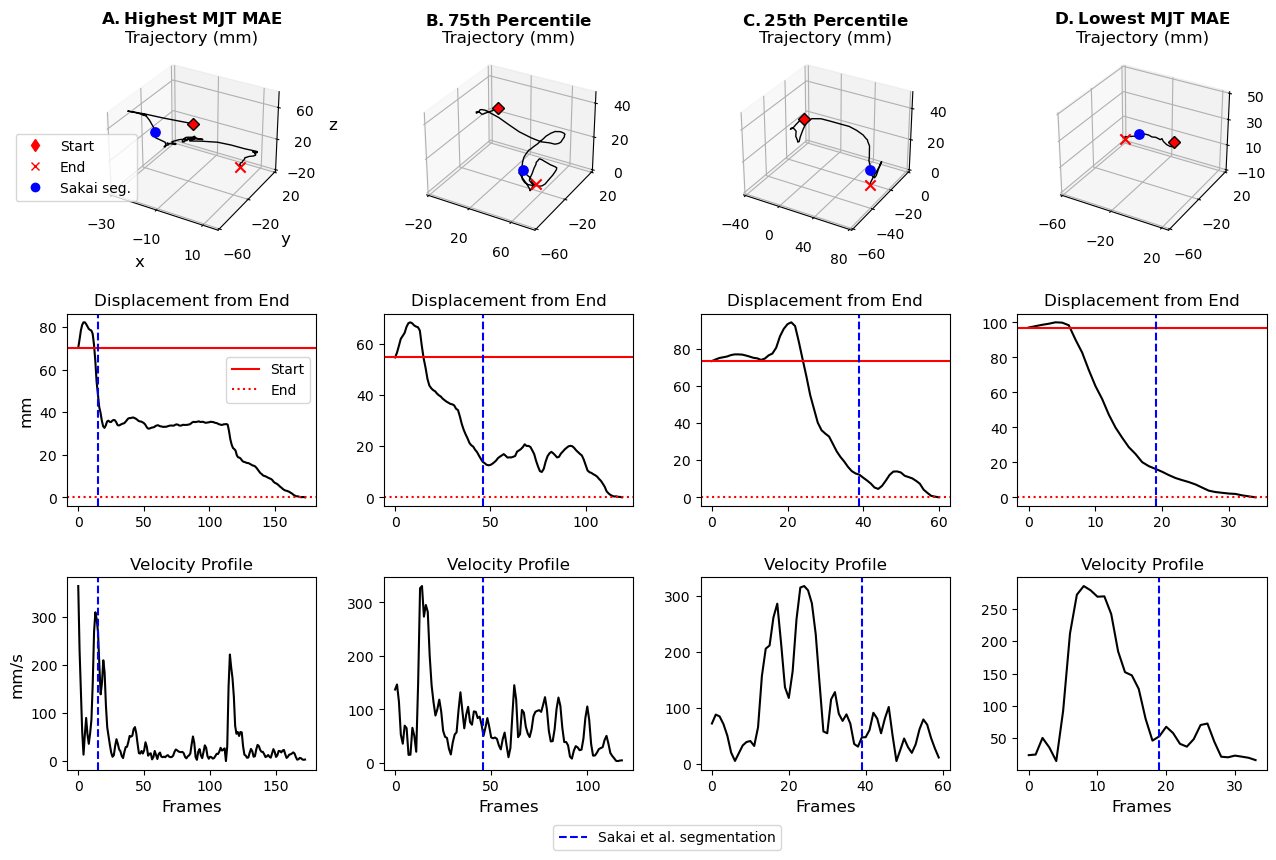

In [9]:
# 5th order lowpass butterworth filter with cutoff frequency of 10, sampling at 30 Hz
sos = butter(5, 10, btype='lowpass', output='sos', fs=30)

fig = plt.figure(figsize=(15,9))

# PLOT 1

sub_id = '1_2_4'
subject = 'Subject #1'
trial = 2
df = subject_workbench_data[subject][trial]['data'].copy()
col_names = df.columns
subset = df[df['Stroke#'] == '4']

x_col = np.array(subset[col_names[0]].astype(float))
y_col = np.array(subset[col_names[2]].astype(float))
z_col = np.array(subset[col_names[1]].astype(float))

vel = ue_traj_seg.compute_velocity(x_col, y_col, z_col, frame_rate=30)[0]
vel = sosfiltfilt(sos, vel)
w_vals, w_thresh_indx, seg_indx, traj_displacements = ue_traj_seg.segmentation(x_col, y_col, z_col, vel=vel, alpha=0.4)

# change to sakai method
seg_indx = seg_indx_dict[sub_id]

ax = fig.add_subplot(3,4,1, projection='3d')

ax.scatter(x_col[seg_indx], y_col[seg_indx], z_col[seg_indx], marker='o', c='b', s=45)
ax.scatter(x_col[-1], y_col[-1], z_col[-1], marker='x', c='r', s=55)
ax.plot(x_col, y_col, z_col, color='k', marker='D', markerfacecolor='r', markevery=[0], linewidth=1)

ax.set_title(r"$\bf{" + "A. Highest~MJT~MAE" + "}$" + "\nTrajectory (mm)", y=1.08)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('z', fontsize=12)

ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
ax.set_zticks(ax.get_zticks()[::2])

legend_elements = [
    Line2D([0], [0], color='r', marker='d', linestyle='', label='Start'),
    Line2D([0], [0], color='r', marker='x', linestyle='', label='End'),
    Line2D([0], [0], color='b', marker='o', linestyle='', label='Sakai seg.'),
]
ax.legend(handles=legend_elements, ncol=1, bbox_to_anchor=(0.25, .6))

# ax.tick_params()

ax = fig.add_subplot(3,4,5)

ax.plot(traj_displacements, '-k')
ax.axhline(traj_displacements[0], color='r', linestyle='-', label='Start')
ax.axhline(traj_displacements[-1], color='r', linestyle=':', label='End')
ax.axvline(seg_indx, color='b', linestyle='--', label='Segmentation')
ax.set_ylabel('mm', fontsize=12)

legend_elements = [
    Line2D([0], [0], color='r', linestyle='-', label='Start'),
    Line2D([0], [0], color='r', linestyle=':', label='End'),
]
plt.legend(handles=legend_elements, ncol=1, bbox_to_anchor=(.61, .5))

ax.set_title('Displacement from End')

ax = fig.add_subplot(3,4,9)

ax.plot(vel, '-k')

ax.set_title('Velocity Profile')
ax.set_xlabel('Frames', fontsize=12)
ax.set_ylabel('mm/s', fontsize=12)
ax.axvline(seg_indx, c='b', ls='--', label='Segmentation')
ax.tick_params()

# PLOT 2

sub_id = '5_2_2'
subject = 'Subject #5'
trial = 2
df = subject_workbench_data[subject][trial]['data'].copy()
col_names = df.columns
subset = df[df['Stroke#'] == '2']

x_col = np.array(subset[col_names[0]].astype(float))
y_col = np.array(subset[col_names[2]].astype(float))
z_col = np.array(subset[col_names[1]].astype(float))

vel = ue_traj_seg.compute_velocity(x_col, y_col, z_col, frame_rate=30)[0]
vel = sosfiltfilt(sos, vel)
w_vals, w_thresh_indx, seg_indx, traj_displacements = ue_traj_seg.segmentation(x_col, y_col, z_col, vel=vel, alpha=0.4)

# change to sakai method
seg_indx = seg_indx_dict[sub_id]

ax = fig.add_subplot(3,4,2, projection='3d')

ax.scatter(x_col[seg_indx], y_col[seg_indx], z_col[seg_indx], marker='o', c='b', s=45)
ax.scatter(x_col[-1], y_col[-1], z_col[-1], marker='x', c='r', s=55)
ax.plot(x_col, y_col, z_col, color='k', marker='D', markerfacecolor='r', markevery=[0], linewidth=1)

ax.set_title(r"$\bf{" + "B. 75th~Percentile" + "}$" + "\nTrajectory (mm)", y=1.08)

ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
ax.set_zticks(ax.get_zticks()[::2])
# ax.tick_params()

ax = fig.add_subplot(3,4,6)

ax.plot(traj_displacements, '-k')
ax.axhline(traj_displacements[0], color='r', linestyle='-', label='Start')
ax.axhline(traj_displacements[-1], color='r', linestyle=':', label='End')
ax.axvline(seg_indx, color='b', linestyle='--', label='Segmentation')

ax.set_title('Displacement from End')

ax = fig.add_subplot(3,4,10)

ax.plot(vel, '-k')

ax.set_title('Velocity Profile')
ax.set_xlabel('Frames', fontsize=12)
ax.axvline(seg_indx, c='b', ls='--', label='Segmentation')
ax.tick_params()

# PLOT 3

sub_id = '14_1_2'
subject = 'Subject #14'
trial = 1
df = subject_workbench_data[subject][trial]['data'].copy()
col_names = df.columns
subset = df[df['Stroke#'] == '2']

x_col = np.array(subset[col_names[0]].astype(float))
y_col = np.array(subset[col_names[2]].astype(float))
z_col = np.array(subset[col_names[1]].astype(float))

vel = ue_traj_seg.compute_velocity(x_col, y_col, z_col, frame_rate=30)[0]
vel = sosfiltfilt(sos, vel)
w_vals, w_thresh_indx, seg_indx, traj_displacements = ue_traj_seg.segmentation(x_col, y_col, z_col, vel=vel, alpha=0.4)

# change to sakai method
seg_indx = seg_indx_dict[sub_id]

ax = fig.add_subplot(3,4,3, projection='3d')

ax.scatter(x_col[seg_indx], y_col[seg_indx], z_col[seg_indx], marker='o', c='b', s=45)
ax.scatter(x_col[-1], y_col[-1], z_col[-1], marker='x', c='r', s=55)
ax.plot(x_col, y_col, z_col, color='k', marker='D', markerfacecolor='r', markevery=[0], linewidth=1)

ax.set_title(r"$\bf{" + "C. 25th~Percentile" + "}$" + "\nTrajectory (mm)", y=1.08)

ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
ax.set_zticks(ax.get_zticks()[::2])

ax = fig.add_subplot(3,4,7)

ax.plot(traj_displacements, '-k')
ax.axhline(traj_displacements[0], color='r', linestyle='-', label='Start')
ax.axhline(traj_displacements[-1], color='r', linestyle=':', label='End')
ax.axvline(seg_indx, color='b', linestyle='--', label='Segmentation')

ax.set_title('Displacement from End')

ax = fig.add_subplot(3,4,11)

ax.plot(vel, '-k')

ax.set_title('Velocity Profile')
ax.set_xlabel('Frames', fontsize=12)
ax.axvline(seg_indx, c='b', ls='--', label='Sakai seg.')
ax.tick_params()

legend_elements = [
    Line2D([0], [0], color='b', linestyle='--', label='Sakai et al. segmentation'),
]
plt.legend(handles=legend_elements, ncol=1, bbox_to_anchor=(0.35, -0.25))

# PLOT 4 

sub_id = '7_3_8'
subject = 'Subject #7'
trial = 3
df = subject_workbench_data[subject][trial]['data'].copy()
col_names = df.columns
subset = df[df['Stroke#'] == '8']

x_col = np.array(subset[col_names[0]].astype(float))
y_col = np.array(subset[col_names[2]].astype(float))
z_col = np.array(subset[col_names[1]].astype(float))

vel = ue_traj_seg.compute_velocity(x_col, y_col, z_col, frame_rate=30)[0]
vel = sosfiltfilt(sos, vel)
w_vals, w_thresh_indx, seg_indx, traj_displacements = ue_traj_seg.segmentation(x_col, y_col, z_col, vel=vel, alpha=0.4)

# change to sakai method
seg_indx = seg_indx_dict[sub_id]

ax = fig.add_subplot(3,4,4, projection='3d')

ax.scatter(x_col[seg_indx], y_col[seg_indx], z_col[seg_indx], marker='o', c='b', s=45)
ax.scatter(x_col[-1], y_col[-1], z_col[-1], marker='x', c='r', s=55)
ax.plot(x_col, y_col, z_col, color='k', marker='D', markerfacecolor='r', markevery=[0], linewidth=1)

ax.set_title(r"$\bf{" + "D. Lowest~MJT~MAE" + "}$" + "\nTrajectory (mm)", y=1.08)

ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
ax.set_zticks(ax.get_zticks()[::2])
# ax.tick_params()

ax = fig.add_subplot(3,4,8)

ax.plot(traj_displacements, '-k')
ax.axhline(traj_displacements[0], color='r', linestyle='-', label='Start')
ax.axhline(traj_displacements[-1], color='r', linestyle=':', label='End')
ax.axvline(seg_indx, color='b', linestyle='--', label='Segmentation')

ax.set_title('Displacement from End')

ax = fig.add_subplot(3,4,12)

ax.plot(vel, '-k')

ax.set_title('Velocity Profile')
ax.set_xlabel('Frames', fontsize=12)
ax.axvline(seg_indx, c='b', ls='--', label='Segmentation')

ax.tick_params()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.27, 
                    hspace=0.37)

plt.savefig('hve_convergence.png', dpi=300)

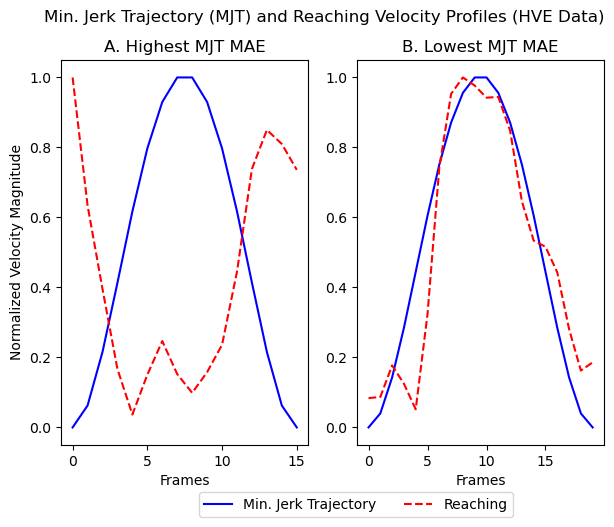

In [16]:
# MJT error demonstration plots

fig = plt.figure(figsize=(7,5))
fig.suptitle("Min. Jerk Trajectory (MJT) and Reaching Velocity Profiles (HVE Data)")

ax = fig.add_subplot(1,2,1)

ax.plot(errors_dict['1_2_4']['mjt_vel']/max(errors_dict['1_2_4']['mjt_vel']), '-', label='MJT', color='b')
ax.plot(errors_dict['1_2_4']['real_vel']/max(errors_dict['1_2_4']['real_vel']), '--', label='Reaching', color='r')
ax.set_ylabel('Normalized Velocity Magnitude')
ax.set_xlabel('Frames')
ax.set_title('A. Highest MJT MAE')
# ax.legend()

ax = fig.add_subplot(1,2,2)
ax.plot(errors_dict['7_3_8']['mjt_vel']/max(errors_dict['7_3_8']['mjt_vel']), '-', label='MJT', color='b')
ax.plot(errors_dict['7_3_8']['real_vel']/max(errors_dict['7_3_8']['real_vel']), '--', label='Reaching', color='r')
ax.set_title('B. Lowest MJT MAE')
# ax.legend()

legend_elements = [
    Line2D([0], [0], color='b', linestyle='-', label='Min. Jerk Trajectory'),
    Line2D([0], [0], color='r', linestyle='--', label='Reaching'),
]

fig.legend(handles=legend_elements, bbox_to_anchor=(0.78,0.03), ncol=2)

ax.set_xlabel('Frames')
# plt.tight_layout()
plt.savefig('mjt_vs_real.png', dpi=300, bbox_inches='tight')

### Plot labels

In [94]:
def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    
    Source: https://stackoverflow.com/a/56955897
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [95]:
# read in labels
df = pd.read_csv('C:\\Users\\kjack\\Documents\\Mason\\Research\\seg_labels\\TBME_labels\\final_HVE_labels.csv')

lookup_dict = {
    0 : 'Acceptable',
    1 : 'Questionable',
    2 : 'Ambiguous'
}

In [96]:
df['jackson_values'] = df.apply(lambda x: all_stats_dict['jackson'][x['id']], axis=1)
df['jackson_labels'] = df.apply(lambda x: lookup_dict[x['jackson']], axis=1)

df['kinematic_values'] = df.apply(lambda x: all_stats_dict['kinematic'][x['id']], axis=1)
df['kinematic_labels'] = df.apply(lambda x: lookup_dict[x['kinematic']], axis=1)

df['jackson_no_d_values'] = df.apply(lambda x: all_stats_dict['jackson_no_d'][x['id']], axis=1)
df['jackson_no_d_labels'] = df.apply(lambda x: lookup_dict[x['jackson_no_d']], axis=1)

df['50_percent_values'] = df.apply(lambda x: all_stats_dict['50_percent'][x['id']], axis=1)
df['50_percent_labels'] = df.apply(lambda x: lookup_dict[x['50_percent']], axis=1)

df['sakai_values'] = df.apply(lambda x: all_stats_dict['sakai'][x['id']], axis=1)
df['sakai_labels'] = df.apply(lambda x: lookup_dict[x['sakai']], axis=1)

In [97]:
print("Total samples:", len(df))
ambiguous_count = df['jackson'].value_counts()[2]
print("Ambiguous Samples:", ambiguous_count)

print("\nSummary stats without ambiguous samples:")

print("\n50% Movement")
print("Acceptable count:", df['50_percent'].value_counts()[0])
print("Acceptable proportion", df['50_percent'].value_counts()[0]/(len(df)-ambiguous_count))

print("\nKinematic")
print("Acceptable count:", df['kinematic'].value_counts()[0])
print("Acceptable proportion", df['kinematic'].value_counts()[0]/(len(df)-ambiguous_count))

print("\nJackson")
print("Acceptable count:", df['jackson'].value_counts()[0])
print("Acceptable proportion", df['jackson'].value_counts()[0]/(len(df)-ambiguous_count))

print("\nJackson w/o Displacement Threshold")
print("Acceptable count:", df['jackson_no_d'].value_counts()[0])
print("Acceptable proportion", df['jackson_no_d'].value_counts()[0]/(len(df)-ambiguous_count))

print("\nJackson + Sakai")
print("Acceptable count:", df['sakai'].value_counts()[0])
print("Acceptable proportion", df['sakai'].value_counts()[0]/(len(df)-ambiguous_count))

Total samples: 305
Ambiguous Samples: 24

Summary stats without ambiguous samples:

50% Movement
Acceptable count: 105
Acceptable proportion 0.3736654804270463

Kinematic
Acceptable count: 248
Acceptable proportion 0.8825622775800712

Jackson
Acceptable count: 245
Acceptable proportion 0.8718861209964412

Jackson w/o Displacement Threshold
Acceptable count: 220
Acceptable proportion 0.7829181494661922

Jackson + Sakai
Acceptable count: 248
Acceptable proportion 0.8825622775800712


In [98]:
# the order of the notch plots in the rain cloud plot is determined by the order of the labels
# so I need to order them beforehand, which is a bit of a hack
def conditions(s):
    if (s['labels'] == 'Acceptable'):
        return 0
    elif (s['labels'] == 'Questionable'):
        return 1
    else:
        return 2

In [99]:
# initialize df for rain cloud plots
# 50_percent
first_df = df[['id', '50_percent_values', '50_percent_labels']]
my_dict = {'group':'50_percent'}
overall_df = first_df.assign(**my_dict)
overall_df.rename(columns={'50_percent_values':'values','50_percent_labels':'labels'}, inplace=True)
overall_df['Class'] = overall_df.apply(conditions, axis=1)
overall_df = overall_df.sort_values('Class')

# other categoires to be appended
# kinematic
next_df = df[['id', 'kinematic_values', 'kinematic_labels']]
my_dict = {'group':'kinematic'}
next_df = next_df.assign(**my_dict)
next_df.rename(columns={'kinematic_values':'values','kinematic_labels':'labels'}, inplace=True)
overall_df = pd.concat([overall_df, next_df])

# jackson
next_df = df[['id', 'jackson_values', 'jackson_labels']]
my_dict = {'group':'jackson'}
next_df = next_df.assign(**my_dict)
next_df.rename(columns={'jackson_values':'values','jackson_labels':'labels'}, inplace=True)
overall_df = pd.concat([overall_df, next_df])

# jackson_no_d
next_df = df[['id', 'jackson_no_d_values', 'jackson_no_d_labels']]
my_dict = {'group':'jackson_no_d'}
next_df = next_df.assign(**my_dict)
next_df.rename(columns={'jackson_no_d_values':'values','jackson_no_d_labels':'labels'}, inplace=True)
overall_df = pd.concat([overall_df, next_df])

# sakai
next_df = df[['id', 'sakai_values', 'sakai_labels']]
my_dict = {'group':'sakai'}
next_df = next_df.assign(**my_dict)
next_df.rename(columns={'sakai_values':'values','sakai_labels':'labels'}, inplace=True)
overall_df = pd.concat([overall_df, next_df])

C:\Users\kjack\AppData\Local\Temp\ipykernel_4584\371412246.py:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


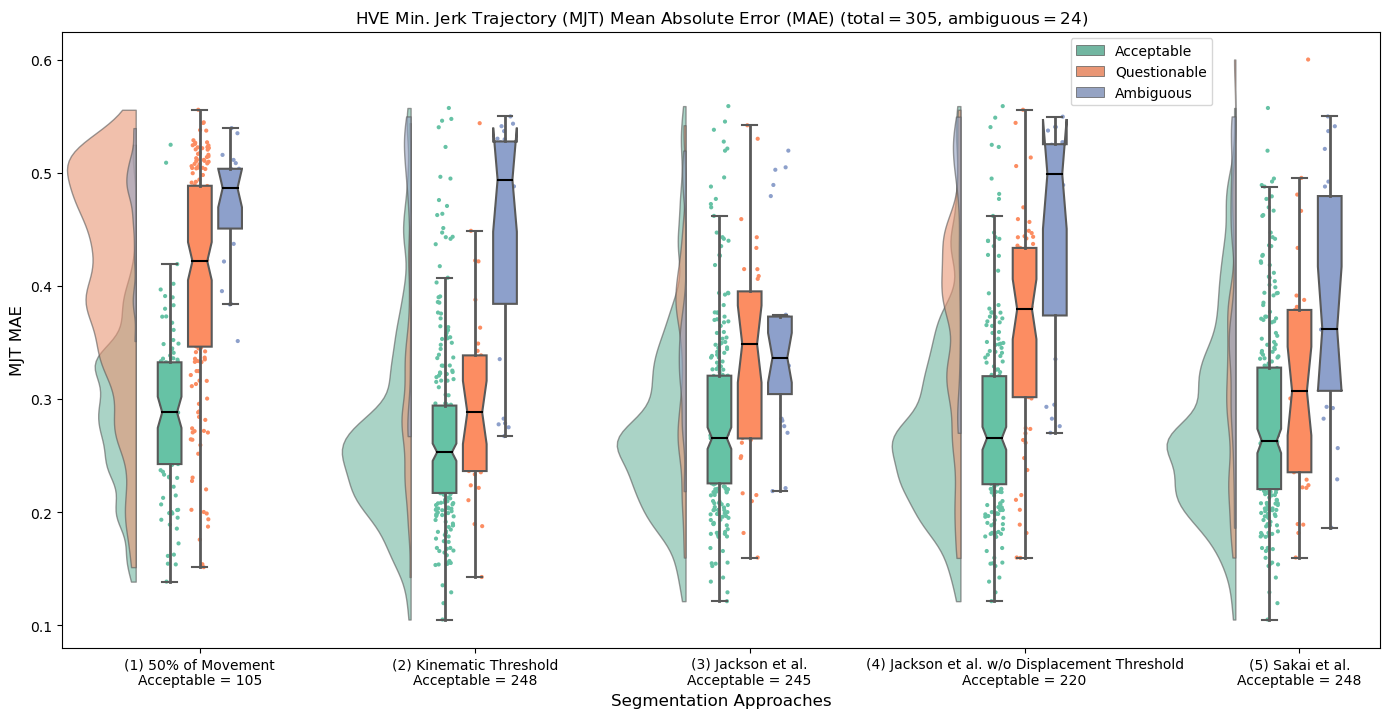

In [47]:
dy = "values"
dx = "group"
ort = "v"
dhue = "labels"
pal = "Set2"
sigma = 0.2
jitter = 1
dodge=True

f, ax = plt.subplots(figsize=(17,8))

ax=pt.RainCloud(x = dx, y = dy, hue = dhue, palette=pal, data = overall_df, \
                scale='count', bw = sigma, jitter=1, width_viol = 0.5, width_box=.33, \
                ax = ax, orient = ort , alpha = 0.6, dodge = dodge, box_fliersize=0, box_notch=True, box_medianprops={"color": "black", 'zorder':10})

ax.set_ylabel('MJT MAE', fontsize=12)
ax.set_xlabel('Segmentation Approaches', fontsize=12)
plt.title("HVE Min. Jerk Trajectory (MJT) Mean Absolute Error (MAE) (total$=305$, ambiguous$=24$)")
ax.set_xticklabels(['(1) 50% of Movement\nAcceptable = 105', '(2) Kinematic Threshold\nAcceptable = 248', '(3) Jackson et al.\nAcceptable = 245', '(4) Jackson et al. w/o Displacement Threshold\nAcceptable = 220', '(5) Sakai et al.\nAcceptable = 248'])
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=[handles[0], handles[1], handles[2]], labels=[labels[0], labels[1], labels[2]], bbox_to_anchor=(0.76,1), loc='upper left')
adjust_box_widths(f, 0.8)

ax.get_figure().savefig('hve_mjt_mae_raincloud.png', bbox_inches='tight', dpi=300)

Plot in 3D if needed

In [30]:
subject = 'Subject #4'
trial = 1
df = subject_workbench_data[subject][trial]['data'].copy()
col_names = df.columns
subset = df[df['Stroke#'] == '2']

x_pos = np.array(subset[col_names[0]].astype(float))
y_pos = np.array(subset[col_names[2]].astype(float))
z_pos = np.array(subset[col_names[1]].astype(float))

ploting_df = pd.DataFrame(zip(x_pos, y_pos, z_pos), columns=['x', 'y', 'z'])
fig = px.line_3d(ploting_df, x='x', y='y', z='z')
fig.show()

# Targeted Box and Blocks
<a id='c'></a>

In [21]:
# read in data from analysis.ipynb
with open('tbbt_data.pkl', 'rb') as f:
    tbbt_data = pickle.load(f)

In [22]:
for k in tbbt_data.keys():
    
    vel = tbbt_data[k]['vel']
    x = tbbt_data[k]['x']
    y = tbbt_data[k]['y']
    z = tbbt_data[k]['z']
    
    # get segmentation indices
    seg_indices = {}
    # 50 percent
    seg_indices['50_percent'] = round(len(vel) * .5)
    # kinematic
    seg_indices['kinematic'] = ue_traj_seg.kin_threshold_and_zerocrossing(x, y, z, vel=vel)
    # jackson
    w_vals, w_thresh_indx, seg_indx, traj_displacement = ue_traj_seg.segmentation(x, y, z, vel=vel, framerate=100, alpha=0.4)
    seg_indices['jackson'] = seg_indx
    tbbt_data[k]['displacement'] = traj_displacement
    # jackson w/o displacement
    w_vals, w_thresh_indx, seg_indx, traj_displacement = ue_traj_seg.segmentation(x, y, z, vel=vel, framerate=100, alpha=0.4, d_threshold=False)
    seg_indices['jackson_no_d'] = seg_indx
    # sakai
    approx_ep = ue_traj_seg.find_approx_endpoint(x, y, z, c_1=2, c_2=3, vel=vel, use_c2=True, alpha=0.4)
    if approx_ep[0] is None:
        se = approx_ep[4]
    else:
        se = approx_ep[2]
    seg_indices['sakai'] = se
    tbbt_data[k]['seg_indices'] = seg_indices.copy()
    
    # compute mjt errors for each segmentation approach
    mjt_mae = {}
    for seg_approach, index in seg_indices.items():
        mjt = ue_traj_seg.min_jerk_traj_vel(x, y, z, index)
        mjt_mae[seg_approach] = np.mean(np.abs(ue_traj_seg.mjt_error(mjt, vel[:index+1])))
    tbbt_data[k]['mjt_mae'] = mjt_mae.copy()

#### MJT MAE plot with examples, Sakai method

In [23]:
sakai_tracker = {}
for k, v in tbbt_data.items():
    sakai_tracker[k] = v['mjt_mae']['sakai']

In [24]:
# Keys for min, median, and max absolute mean values
print("Absolute Mean")
print("max:", max(sakai_tracker, key=sakai_tracker.get))

prep_list = [(k,v) for k,v in sakai_tracker.items()]
vals_list = [i[1] for i in prep_list]
med_indx = vals_list.index(np.percentile(vals_list, 75, method='closest_observation'))
print('75%:', prep_list[med_indx][0])

prep_list = [(k,v) for k,v in sakai_tracker.items()]
vals_list = [i[1] for i in prep_list]
med_indx = vals_list.index(np.percentile(vals_list, 25, method='closest_observation'))
print('25%:', prep_list[med_indx][0])

print("min:", min(sakai_tracker, key=sakai_tracker.get))

Absolute Mean
max: ab44_2_4
75%: ab44_1_3
25%: ab44_2_11
min: ab44_2_15


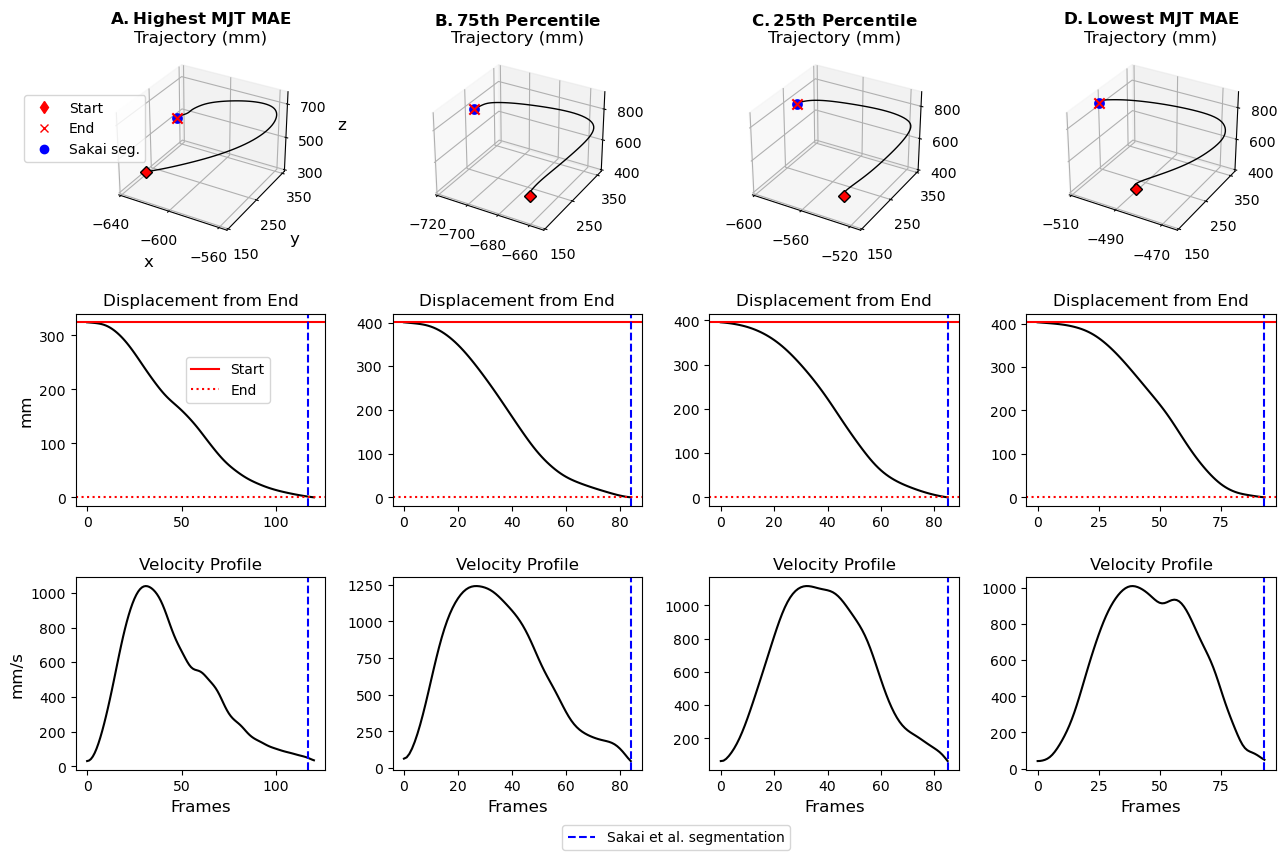

In [137]:
# 5th order lowpass butterworth filter with cutoff frequency of 10, sampling at 30 Hz
sos = butter(5, 10, btype='lowpass', output='sos', fs=30)

fig = plt.figure(figsize=(15,9))

# PLOT 1

sub_id = 'ab44_2_4'

x_col = tbbt_data[sub_id]['x']
y_col = tbbt_data[sub_id]['y']
z_col = tbbt_data[sub_id]['z']

vel = tbbt_data[sub_id]['vel']
w_vals, w_thresh_indx, seg_indx, traj_displacements = ue_traj_seg.segmentation(x_col, y_col, z_col, vel=vel, alpha=0.4)

# change to sakai method
seg_indx = tbbt_data[sub_id]['seg_indices']['sakai']

ax = fig.add_subplot(3,4,1, projection='3d')

ax.scatter(x_col[seg_indx], y_col[seg_indx], z_col[seg_indx], marker='o', c='b', s=45)
ax.scatter(x_col[-1], y_col[-1], z_col[-1], marker='x', c='r', s=55)
ax.plot(x_col, y_col, z_col, color='k', marker='D', markerfacecolor='r', markevery=[0], linewidth=1)

ax.set_title(r"$\bf{" + "A. Highest~MJT~MAE" + "}$" + "\nTrajectory (mm)", y=1.08)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('z', fontsize=12)

ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
ax.set_zticks(ax.get_zticks()[::2])

legend_elements = [
    Line2D([0], [0], color='r', marker='d', linestyle='', label='Start'),
    Line2D([0], [0], color='r', marker='x', linestyle='', label='End'),
    Line2D([0], [0], color='b', marker='o', linestyle='', label='Sakai seg.'),
]
ax.legend(handles=legend_elements, ncol=1, bbox_to_anchor=(0.25, .8))

ax = fig.add_subplot(3,4,5)

ax.plot(traj_displacements, '-k')
ax.axhline(traj_displacements[0], color='r', linestyle='-', label='Start')
ax.axhline(traj_displacements[-1], color='r', linestyle=':', label='End')
ax.axvline(seg_indx, color='b', linestyle='--', label='Segmentation')
ax.set_ylabel('mm', fontsize=12)

legend_elements = [
    Line2D([0], [0], color='r', linestyle='-', label='Start'),
    Line2D([0], [0], color='r', linestyle=':', label='End'),
]
plt.legend(handles=legend_elements, ncol=1, bbox_to_anchor=(.61, .5))

ax.set_title('Displacement from End')

ax = fig.add_subplot(3,4,9)

ax.plot(vel, '-k')

ax.set_title('Velocity Profile')
ax.set_xlabel('Frames', fontsize=12)
ax.set_ylabel('mm/s', fontsize=12)
ax.axvline(seg_indx, c='b', ls='--', label='Segmentation')
ax.tick_params()

# PLOT 2

sub_id = 'ab44_1_3'

x_col = tbbt_data[sub_id]['x']
y_col = tbbt_data[sub_id]['y']
z_col = tbbt_data[sub_id]['z']

vel = tbbt_data[sub_id]['vel']
w_vals, w_thresh_indx, seg_indx, traj_displacements = ue_traj_seg.segmentation(x_col, y_col, z_col, vel=vel, alpha=0.4)

# change to sakai method
seg_indx = tbbt_data[sub_id]['seg_indices']['sakai']

ax = fig.add_subplot(3,4,2, projection='3d')

ax.scatter(x_col[seg_indx], y_col[seg_indx], z_col[seg_indx], marker='o', c='b', s=45)
ax.scatter(x_col[-1], y_col[-1], z_col[-1], marker='x', c='r', s=55)
ax.plot(x_col, y_col, z_col, color='k', marker='D', markerfacecolor='r', markevery=[0], linewidth=1)

ax.set_title(r"$\bf{" + "B. 75th~Percentile" + "}$" + "\nTrajectory (mm)", y=1.08)

ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
ax.set_zticks(ax.get_zticks()[::2])

ax = fig.add_subplot(3,4,6)

ax.plot(traj_displacements, '-k')
ax.axhline(traj_displacements[0], color='r', linestyle='-', label='Start')
ax.axhline(traj_displacements[-1], color='r', linestyle=':', label='End')
ax.axvline(seg_indx, color='b', linestyle='--', label='Segmentation')

ax.set_title('Displacement from End')
# ax.legend()


ax = fig.add_subplot(3,4,10)

ax.plot(vel, '-k')

ax.set_title('Velocity Profile')
ax.set_xlabel('Frames', fontsize=12)
ax.axvline(seg_indx, c='b', ls='--', label='Segmentation')
ax.tick_params()

# PLOT 3

sub_id = 'ab44_2_11'

x_col = tbbt_data[sub_id]['x']
y_col = tbbt_data[sub_id]['y']
z_col = tbbt_data[sub_id]['z']

vel = tbbt_data[sub_id]['vel']
w_vals, w_thresh_indx, seg_indx, traj_displacements = ue_traj_seg.segmentation(x_col, y_col, z_col, vel=vel, alpha=0.4)

# change to sakai method
seg_indx = tbbt_data[sub_id]['seg_indices']['sakai']

ax = fig.add_subplot(3,4,3, projection='3d')

ax.scatter(x_col[seg_indx], y_col[seg_indx], z_col[seg_indx], marker='o', c='b', s=45)
ax.scatter(x_col[-1], y_col[-1], z_col[-1], marker='x', c='r', s=55)
ax.plot(x_col, y_col, z_col, color='k', marker='D', markerfacecolor='r', markevery=[0], linewidth=1)

ax.set_title(r"$\bf{" + "C. 25th~Percentile" + "}$" + "\nTrajectory (mm)", y=1.08)

ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
ax.set_zticks(ax.get_zticks()[::2])

ax = fig.add_subplot(3,4,7)

ax.plot(traj_displacements, '-k')
ax.axhline(traj_displacements[0], color='r', linestyle='-', label='Start')
ax.axhline(traj_displacements[-1], color='r', linestyle=':', label='End')
ax.axvline(seg_indx, color='b', linestyle='--', label='Segmentation')

ax.set_title('Displacement from End')

ax = fig.add_subplot(3,4,11)

ax.plot(vel, '-k')

ax.set_title('Velocity Profile')
ax.set_xlabel('Frames', fontsize=12)
ax.axvline(seg_indx, c='b', ls='--', label='Sakai seg.')
ax.tick_params()


legend_elements = [
    Line2D([0], [0], color='b', linestyle='--', label='Sakai et al. segmentation'),
]
plt.legend(handles=legend_elements, ncol=1, bbox_to_anchor=(0.35, -0.25))

# PLOT 4 

sub_id = 'ab44_2_15'

x_col = tbbt_data[sub_id]['x']
y_col = tbbt_data[sub_id]['y']
z_col = tbbt_data[sub_id]['z']

vel = tbbt_data[sub_id]['vel']
w_vals, w_thresh_indx, seg_indx, traj_displacements = ue_traj_seg.segmentation(x_col, y_col, z_col, vel=vel, alpha=0.4)

# change to sakai method
seg_indx = tbbt_data[sub_id]['seg_indices']['sakai']

ax = fig.add_subplot(3,4,4, projection='3d')

ax.scatter(x_col[seg_indx], y_col[seg_indx], z_col[seg_indx], marker='o', c='b', s=45)
ax.scatter(x_col[-1], y_col[-1], z_col[-1], marker='x', c='r', s=55)
ax.plot(x_col, y_col, z_col, color='k', marker='D', markerfacecolor='r', markevery=[0], linewidth=1)

ax.set_title(r"$\bf{" + "D. Lowest~MJT~MAE" + "}$" + "\nTrajectory (mm)", y=1.08)

ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
ax.set_zticks(ax.get_zticks()[::2])

ax = fig.add_subplot(3,4,8)

ax.plot(traj_displacements, '-k')
ax.axhline(traj_displacements[0], color='r', linestyle='-', label='Start')
ax.axhline(traj_displacements[-1], color='r', linestyle=':', label='End')
ax.axvline(seg_indx, color='b', linestyle='--', label='Segmentation')

ax.set_title('Displacement from End')

ax = fig.add_subplot(3,4,12)

ax.plot(vel, '-k')

ax.set_title('Velocity Profile')
ax.set_xlabel('Frames', fontsize=12)
ax.axvline(seg_indx, c='b', ls='--', label='Segmentation')

ax.tick_params()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.27, 
                    hspace=0.37)

plt.savefig('tbbt_convergence.png', dpi=300)

#### MJT MAE Notch plots

In [25]:
# write out segmentation results for labeling

for k, v in tbbt_data.items():
    f_path = 'C:\\Users\\kjack\\Documents\\Mason\\Research\\UE-traj-seg\\notebooks\\supplemental_materials\\tbbt_results\\' + k + ".png"
    se_list = [(_k, _v) for _k, _v in tbbt_data[k]['seg_indices'].items()]
    ue_traj_seg.viz_all_seg_result(f_path=f_path, x=v['x'], y=v['y'], z=v['z'], vel=v['vel'], w_vals=v['displacement'], se_list=se_list)

In [72]:
# read in labels
df = pd.read_csv('C:\\Users\\kjack\\Documents\\Mason\\Research\\UE-traj-seg\\notebooks\\supplemental_materials\\tbbt_labels.csv')

lookup_dict = {
    0 : 'Acceptable',
    1 : 'Questionable',
    2 : 'Ambiguous'
}

In [73]:
df['jackson_values'] = df.apply(lambda x: {k:v['mjt_mae']['jackson'] for (k,v) in tbbt_data.items()}[x['id']], axis=1)
df['jackson_labels'] = df.apply(lambda x: lookup_dict[x['jackson']], axis=1)

df['kinematic_values'] = df.apply(lambda x: {k:v['mjt_mae']['kinematic'] for (k,v) in tbbt_data.items()}[x['id']], axis=1)
df['kinematic_labels'] = df.apply(lambda x: lookup_dict[x['kinematic']], axis=1)

df['jackson_no_d_values'] = df.apply(lambda x: {k:v['mjt_mae']['jackson_no_d'] for (k,v) in tbbt_data.items()}[x['id']], axis=1)
df['jackson_no_d_labels'] = df.apply(lambda x: lookup_dict[x['jackson_no_d']], axis=1)

df['50_percent_values'] = df.apply(lambda x: {k:v['mjt_mae']['50_percent'] for (k,v) in tbbt_data.items()}[x['id']], axis=1)
df['50_percent_labels'] = df.apply(lambda x: lookup_dict[x['50_percent']], axis=1)

df['sakai_values'] = df.apply(lambda x: {k:v['mjt_mae']['sakai'] for (k,v) in tbbt_data.items()}[x['id']], axis=1)
df['sakai_labels'] = df.apply(lambda x: lookup_dict[x['sakai']], axis=1)

In [74]:
print("Total samples:", len(df))
if len(df['jackson'].value_counts()) == 2:
    ambiguous_count = 0
else:
    ambiguous_count = df['jackson'].value_counts()[2]
    
print("Ambiguous Samples:", ambiguous_count)

print("\nSummary stats without ambiguous samples:")

print("\n50% Movement")
print("Acceptable count:", df['50_percent'].value_counts()[0])
print("Acceptable proportion", df['50_percent'].value_counts()[0]/(len(df)-ambiguous_count))

print("\nKinematic")
print("Acceptable count:", df['kinematic'].value_counts()[0])
print("Acceptable proportion", df['kinematic'].value_counts()[0]/(len(df)-ambiguous_count))

print("\nJackson")
print("Acceptable count:", df['jackson'].value_counts()[0])
print("Acceptable proportion", df['jackson'].value_counts()[0]/(len(df)-ambiguous_count))

print("\nJackson w/o Displacement Threshold")
print("Acceptable count:", df['jackson_no_d'].value_counts()[0])
print("Acceptable proportion", df['jackson_no_d'].value_counts()[0]/(len(df)-ambiguous_count))

print("\nSakai")
print("Acceptable count:", df['sakai'].value_counts()[0])
print("Acceptable proportion", df['sakai'].value_counts()[0]/(len(df)-ambiguous_count))

Total samples: 63
Ambiguous Samples: 0

Summary stats without ambiguous samples:

50% Movement
Acceptable count: 2
Acceptable proportion 0.031746031746031744

Kinematic
Acceptable count: 62
Acceptable proportion 0.9841269841269841

Jackson
Acceptable count: 56
Acceptable proportion 0.8888888888888888

Jackson w/o Displacement Threshold
Acceptable count: 34
Acceptable proportion 0.5396825396825397

Sakai
Acceptable count: 62
Acceptable proportion 0.9841269841269841


In [75]:
# the order of the notch plots in the rain cloud plot is determined by the order of the labels
# so I need to order them beforehand, which is a bit of a hack
def conditions(s):
    if (s['labels'] == 'Acceptable'):
        return 0
    elif (s['labels'] == 'Questionable'):
        return 1
    else:
        return 2

In [76]:
# initialize df for rain cloud plots
# 50_percent
first_df = df[['id', '50_percent_values', '50_percent_labels']]
my_dict = {'group':'50_percent'}
overall_df = first_df.assign(**my_dict)
overall_df.rename(columns={'50_percent_values':'values','50_percent_labels':'labels'}, inplace=True)
overall_df['Class'] = overall_df.apply(conditions, axis=1)
overall_df = overall_df.sort_values('Class')

# other categoires to be appended
# kinematic
next_df = df[['id', 'kinematic_values', 'kinematic_labels']]
my_dict = {'group':'kinematic'}
next_df = next_df.assign(**my_dict)
next_df.rename(columns={'kinematic_values':'values','kinematic_labels':'labels'}, inplace=True)
# overall_df = overall_df.append(next_df)
overall_df = pd.concat([overall_df, next_df])

# jackson
next_df = df[['id', 'jackson_values', 'jackson_labels']]
my_dict = {'group':'jackson'}
next_df = next_df.assign(**my_dict)
next_df.rename(columns={'jackson_values':'values','jackson_labels':'labels'}, inplace=True)
overall_df = pd.concat([overall_df, next_df])

# jackson_no_d
next_df = df[['id', 'jackson_no_d_values', 'jackson_no_d_labels']]
my_dict = {'group':'jackson_no_d'}
next_df = next_df.assign(**my_dict)
next_df.rename(columns={'jackson_no_d_values':'values','jackson_no_d_labels':'labels'}, inplace=True)
overall_df = pd.concat([overall_df, next_df])

# sakai
next_df = df[['id', 'sakai_values', 'sakai_labels']]
my_dict = {'group':'sakai'}
next_df = next_df.assign(**my_dict)
next_df.rename(columns={'sakai_values':'values','sakai_labels':'labels'}, inplace=True)
overall_df = pd.concat([overall_df, next_df])

C:\Users\kjack\AppData\Local\Temp\ipykernel_4584\371412246.py:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


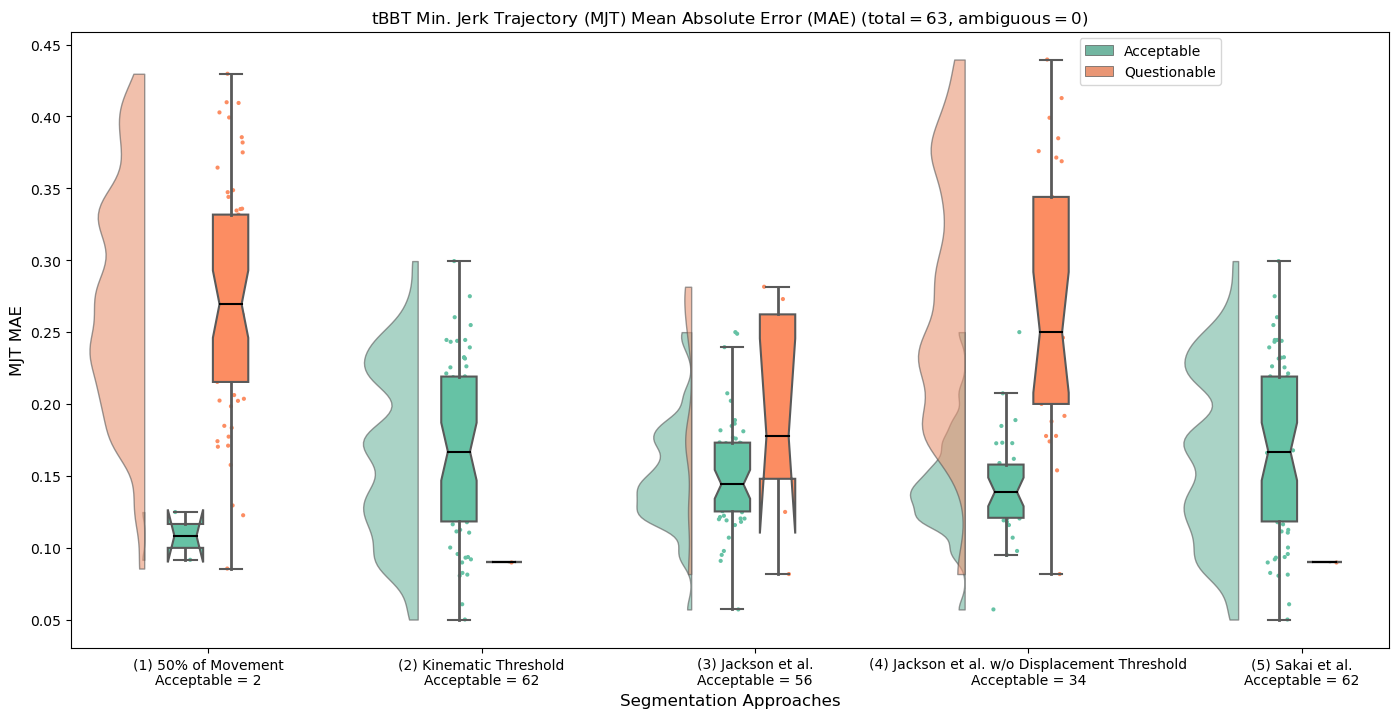

In [55]:
dy = "values"
dx = "group"
ort = "v"
dhue = "labels"
pal = "Set2"
sigma = 0.2
jitter = 1
dodge=True
# df = overall_df.iloc[::-1]  # order of label determines what color is assigned

f, ax = plt.subplots(figsize=(17,8))

ax=pt.RainCloud(x = dx, y = dy, hue = dhue, palette=pal, data = overall_df, \
                scale='count', bw = sigma, jitter=1, width_viol = 0.4, width_box=.33, \
                ax = ax, orient = ort , alpha = 0.6, dodge = dodge, box_fliersize=0, box_notch=True, box_medianprops={"color": "black", 'zorder':10})


ax.set_ylabel('MJT MAE', fontsize=12)
ax.set_xlabel('Segmentation Approaches', fontsize=12)
plt.title("tBBT Min. Jerk Trajectory (MJT) Mean Absolute Error (MAE) (total$=63$, ambiguous$=0$)")
ax.set_xticklabels(['(1) 50% of Movement\nAcceptable = 2', '(2) Kinematic Threshold\nAcceptable = 62', '(3) Jackson et al.\nAcceptable = 56', '(4) Jackson et al. w/o Displacement Threshold\nAcceptable = 34', '(5) Sakai et al.\nAcceptable = 62'])
# plt.legend(loc='upper left')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=[handles[0], handles[1]], labels=[labels[0], labels[1]], bbox_to_anchor=(0.76,1), loc='upper left')
adjust_box_widths(f, 0.8)

# plt.show()
ax.get_figure().savefig('tbbt_mjt_mae_raincloud.png', bbox_inches='tight', dpi=300)